In [1]:
import matplotlib
import numpy as np
import math
import sklearn
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression  
from prompred import *
from IPython.core.display import clear_output
%matplotlib notebook
#%matplotlib notebook
np.core.arrayprint._line_width = 120
warnings.filterwarnings('ignore')

In [2]:
dfDatasetOrder = pd.read_csv("data/pairedDBanalysis.csv")
dfDatasetOrder = dfDatasetOrder.reindex(np.random.permutation(dfDatasetOrder.index))

dfDataset1 = pd.DataFrame(dfDatasetOrder[['ID_1','sequence_1','score_1','35boxstart_1','10boxstart_1']].values,columns=['ID','sequence','mean_score','35boxstart','10boxstart'])
dfDataset2 = pd.DataFrame(dfDatasetOrder[['ID_2','sequence_2','score_2','35boxstart_2','10boxstart_2']].values,columns=['ID','sequence','mean_score','35boxstart','10boxstart'])
posRange = [-42,1]
labels1 , positionBoxSeq1, spacerSeq1 = regionSelect(dfDataset1, [[-5,14],[-8,12]],posRange)
labels2 , positionBoxSeq2, spacerSeq2 = regionSelect(dfDataset2, [[-5,14],[-8,12]], posRange)
positionBox = pd.DataFrame(np.subtract(positionBoxSeq1.values,positionBoxSeq2.values),columns=positionBoxSeq1.columns)

#positionBox = mergePositionDF(positionBoxSeq1, positionBoxSeq2)
positionMatrix = positionBox.values
yString = dfDatasetOrder['rank'].values.astype(str)

# Learning curve with increase of promotor in data

## CLASSIFICATION

<IPython.core.display.Javascript object>


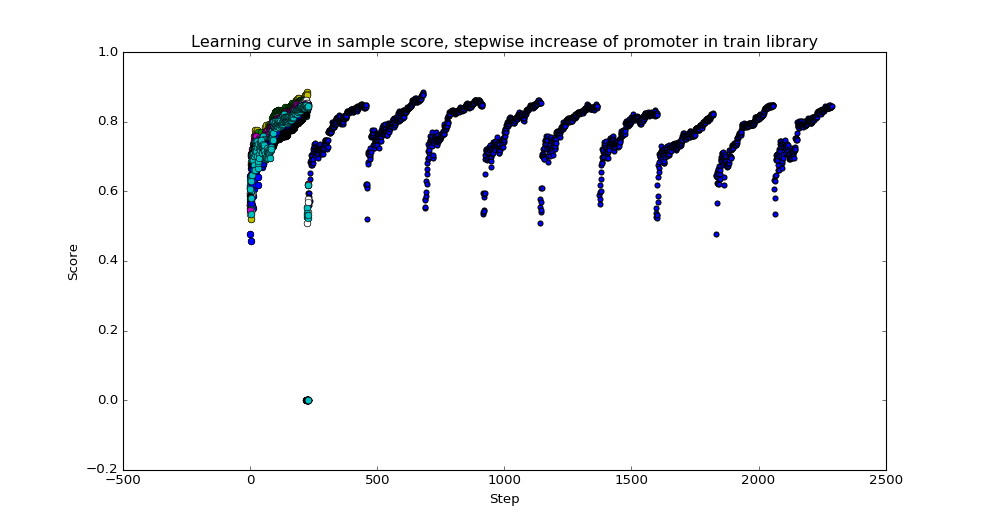

Progress 99.9%

In [28]:
#plt.close('all')

#----parEvalS --------------
Xdf = positionBox
X = positionMatrix
y = yString

regType = 'forestClass'
poly= None

kernel = None

parLabel= "max_depth"
labelValue = 20
##OPTIONAL
n_jobs=16
treeCount = 40
gamma = 0.001
alpha = 0.1
coef0 = 0.01
penalty = 0.1
epsilon = 1.95
#---------------------------

k=10
#

parModel = {"regType":regType, "poly":poly, "kernel":kernel, "treeCount":treeCount, "gamma":gamma, "coef0":coef0, "n_jobs":n_jobs}



dfId = pd.read_csv("data/mut_rand_mod_lib.csv")['ID'] 
dfId = dfId.reindex(np.random.permutation(dfId.index))
lenId = len(dfId)
Id = dfId.values
indexId = np.array(range(lenId))


scores = np.zeros(lenId*k)
it=0
plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.ion()

for i in range(k):
    indexId = np.array(range(lenId))
    boolTest = np.logical_and(indexId>=i*lenId/k,indexId<(i+1)*lenId/k)
    test = Id[boolTest]
    train = Id[np.invert(boolTest)]
    indexTest = (dfDatasetOrder['ID_1'].isin(test) | dfDatasetOrder['ID_2'].isin(test)).values
    dfDatasetTrain = dfDatasetOrder[np.invert(indexTest)]
    X_train, y_train = positionBox[np.invert(indexTest)], yString[np.invert(indexTest)]
    X_test, y_test = positionBox[indexTest], yString[indexTest]
    for j in range(len(train)-1):
        print("\rProgress {:2.1%}".format(it/k+(j/len(train)/k)), end='')
        
        trainInner = train[:(j+2)]
        indexTrainInner = (dfDatasetTrain['ID_1'].isin(trainInner) & dfDatasetTrain['ID_2'].isin(trainInner)).values
        X_trainInner, y_trainInner = X_train[indexTrainInner], y_train[indexTrainInner]
        #print(trainInner, sum(indexTrainInner), len(X_trainInner))
        scores[i*len(train)+j], y_pred = evaluateScore(X_trainInner, X_test, y_trainInner, y_test, {**parModel, parLabel: labelValue})
        
        plt.scatter(i*len(train)+j,  scores[i*len(train)+j])
    it+=1


plt.title("Learning curve in sample score, stepwise increase of promoter in train library")
for i in range(k):
    colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
    plt.plot(range(len(train)),scores[i*len(train):(i+1)*len(train)], colors[i])
plt.xlabel("Step")
plt.ylabel("Score")


## REGRESSION

In [5]:
dfDatasetOrder = pd.read_csv("data/mut_rand_mod_lib.csv")
dfDataset = dfDatasetOrder.reindex(np.random.permutation(dfDatasetOrder.index))
seqRange = [-47,1]
ROI =  [[-12,14],[-8,12]]
labels, positionBoxReg, spacer = regionSelect(dfDataset, ROI, seqRange)

yRooted = [math.sqrt(math.sqrt(u)) for u in labels]


<IPython.core.display.Javascript object>


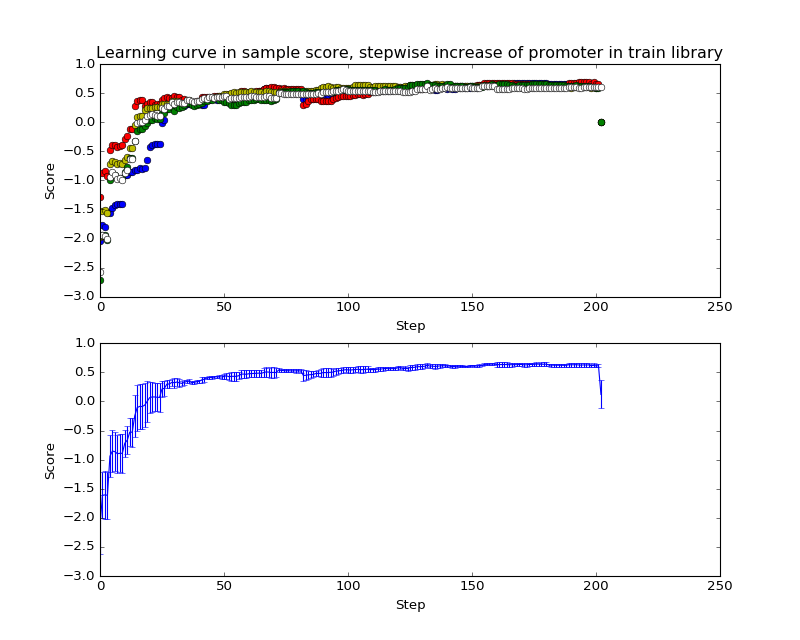

In [13]:
#plt.close('all')

#----parEvalS --------------
Xdf = positionBoxReg
X = positionBoxReg.values
y = np.array(yRooted)

regType = 'ridge'
poly= 3

kernel = 'poly'

parLabel= "alpha"
labelValue = 1
##OPTIONAL
n_jobs=16
treeCount = 40
gamma = 0.1
alpha = 0.1
coef0 = 0.1
penalty = 0.1
epsilon = 1.95
#---------------------------

k=5
#
step=1
parModel = {"regType":regType, "poly":poly, "kernel":kernel, "treeCount":treeCount, "gamma":gamma, "coef0":coef0, "n_jobs":n_jobs}



dfId = pd.read_csv("data/mut_rand_mod_lib.csv")['ID'] 
dfId = dfId.reindex(np.random.permutation(dfId.index))
lenId = len(dfId)
Id = dfId.values
indexId = np.array(range(lenId))


scores = np.zeros([k,lenId*(k-1)/(k)])
it=0

for i in range(k):
    indexId = np.array(range(lenId))
    boolTest = np.logical_and(indexId>=i*lenId/k,indexId<(i+1)*lenId/k)
    test = Id[boolTest]
    train = Id[np.invert(boolTest)]
    indexTest = dfDatasetOrder['ID'].isin(test).values
    dfDatasetTrain = dfDatasetOrder[np.invert(indexTest)]
    X_train, y_train = positionBoxReg[np.invert(indexTest)], y[np.invert(indexTest)]
    X_test, y_test = positionBoxReg[indexTest], y[indexTest]
    for j in range(len(train)-1):
        #print("\rProgress {:2.1%}".format(it/k+(j/len(train)/k)), end='')
        
        trainInner = train[:(j+2)]
        indexTrainInner = (dfDatasetTrain['ID'].isin(trainInner)).values
        X_trainInner, y_trainInner = X_train[indexTrainInner], y_train[indexTrainInner]
        scores[i,j], y_pred = evaluateScore(X_trainInner, X_test, y_trainInner, y_test, {**parModel, parLabel: labelValue})

    it+=1


fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,8))

ax1.set_title("Learning curve in sample score, stepwise increase of promoter in train library")
for i in range(k):
    colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
    ax1.plot(range(len(scores[i,:])),scores[i,:], colors[i])
ax1.set_xlabel("Step")
ax1.set_ylabel("Score")

meanScores=np.mean(scores,axis=0)
stdScores=np.std(scores,axis=0)
ax2.errorbar(range(len(meanScores)), meanScores[:], stdScores[:])
ax2.set_xlabel("Step")
ax2.set_ylabel("Score")


<IPython.core.display.Javascript object>


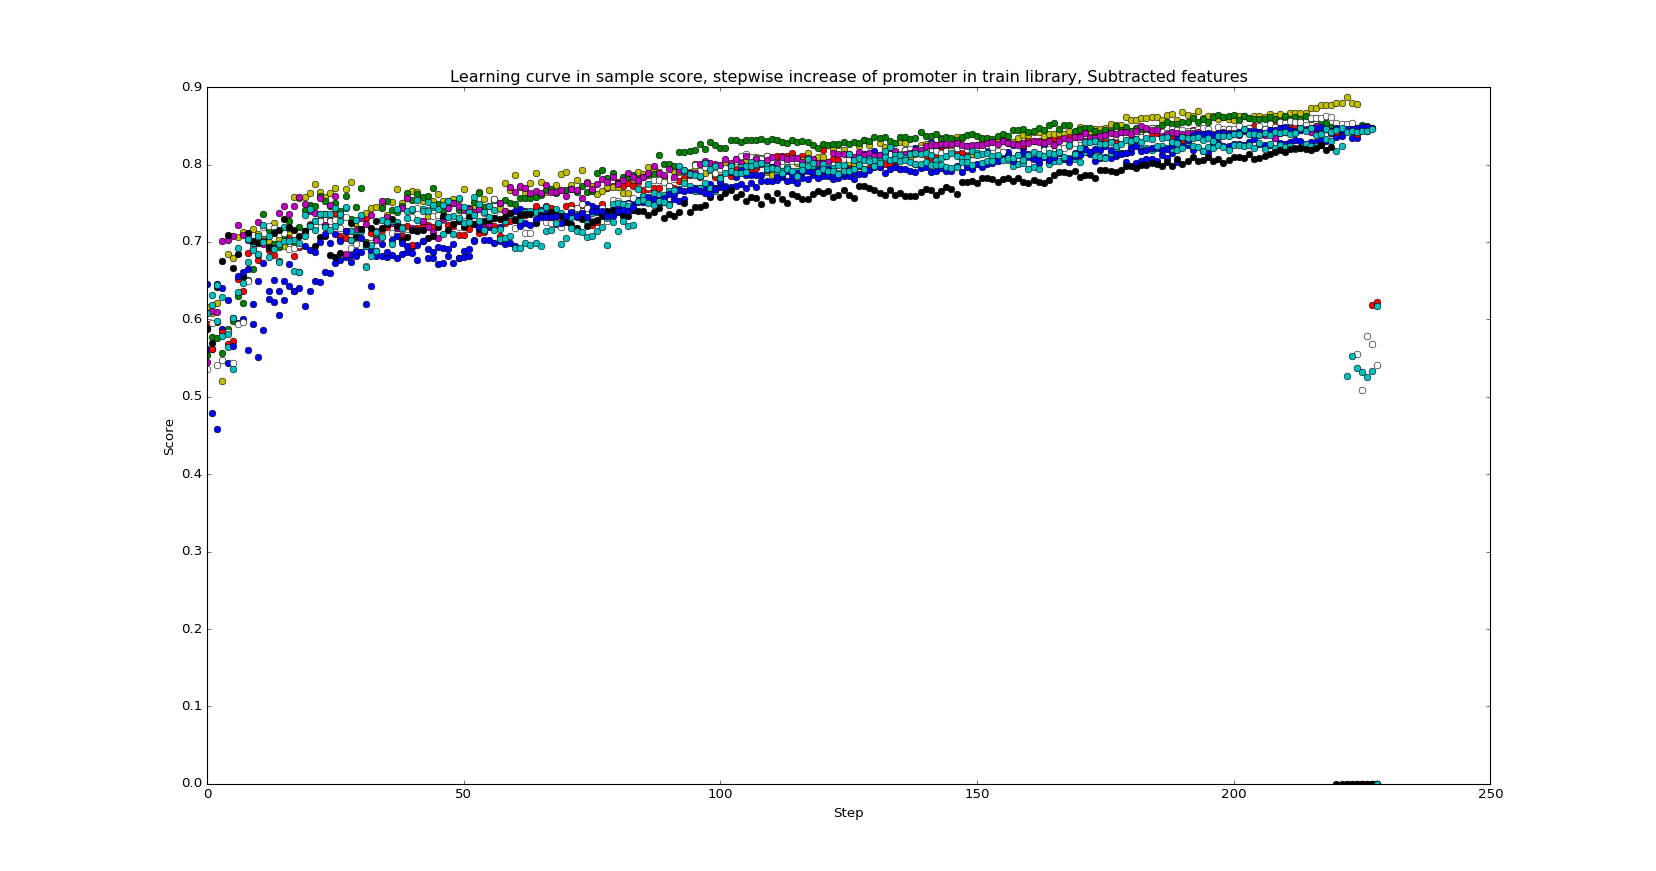

In [43]:
%matplotlib notebook
plt.title("Learning curve in sample score, stepwise increase of promoter in train library, Subtracted features")
for i in range(k):
    colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
    plt.plot(range(len(train)),scores[i*len(train):(i+1)*len(train)], colors[i])
plt.xlabel("Step")
plt.ylabel("Score")

In [7]:
#######################################################
def loadPairwiseDataset(dataset,ROI,posRange):
    dfDatasetOrder = pd.read_csv(dataset)
    dfDatasetOrder['sequence_1'] = dfDatasetOrder['sequence_1'].str.upper()
    dfDatasetOrder['sequence_2'] = dfDatasetOrder['sequence_2'].str.upper()
    dfDatasetOrder = dfDatasetOrder.reindex(np.random.permutation(dfDatasetOrder.index))
    dfDataset1 = pd.DataFrame(dfDatasetOrder[['ID_1','sequence_1','score_1','35boxstart_1','10boxstart_1']].values,columns=['ID','sequence','mean_score','35boxstart','10boxstart'])
    dfDataset2 = pd.DataFrame(dfDatasetOrder[['ID_2','sequence_2','score_2','35boxstart_2','10boxstart_2']].values,columns=['ID','sequence','mean_score','35boxstart','10boxstart'])

    
    labels1 , positionBoxSeq1, spacerSeq1 = regionSelect(dfDataset1, ROI,posRange)
    labels2 , positionBoxSeq2, spacerSeq2 = regionSelect(dfDataset2, ROI, posRange)

    positionBox = pd.DataFrame(np.subtract(positionBoxSeq1.values,positionBoxSeq2.values),columns=positionBoxSeq1.columns)

    yString = dfDatasetOrder['rank'].values.astype(str)
    
    return positionBox, yString

##########################################################

ROI = [[-5,14],[-8,12]]
posRange = [-42,1]

hammerBox, yHammer = loadPairwiseDataset("data/pw_hammer_prom_lib.csv", ROI, posRange)
brewsterBox, yBrewster = loadPairwiseDataset("data/pw_brewster_prom_lib.csv", ROI, posRange)
andersonBox, yAnderson = loadPairwiseDataset("data/pw_anderson_prom_lib.csv", ROI, posRange)
inbioBox, yInbio = loadPairwiseDataset("data/pw_inbio_prom_lib.csv", ROI, posRange)

<IPython.core.display.Javascript object>


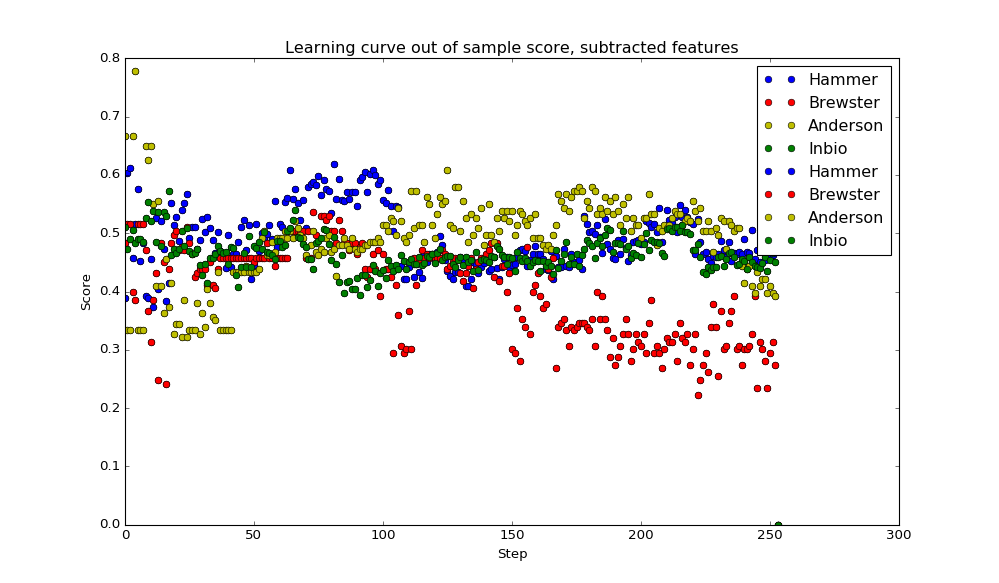

Progress 99.2%

In [44]:
#plt.close('all')

#----parEvalS --------------
Xdf = positionBox
X = positionMatrix
y = yString

regType = 'forestClass'
poly= None

kernel = None

parLabel= "max_depth"
labelValue = 20
##OPTIONAL
n_jobs=15
treeCount = 40
gamma = 0.001
alpha = 0.1
coef0 = 0.01
penalty = 0.1
epsilon = 1.95
#---------------------------

#

parModel = {"regType":regType, "poly":poly, "kernel":kernel, "treeCount":treeCount, "gamma":gamma, "coef0":coef0, "n_jobs":n_jobs}



dfId = pd.read_csv("data/mut_rand_mod_lib.csv")['ID'] 
dfId = dfId.reindex(np.random.permutation(dfId.index))
lenId = len(dfId)
Id = dfId.values
indexId = np.array(range(lenId))


scoresHammer = np.zeros(len(dfId))
scoresBrewster = np.zeros(len(dfId))
scoresAnderson = np.zeros(len(dfId))
scoresInbio = np.zeros(len(dfId))

it=0

plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.ion()


for j in range(len(Id)-1):
    print("\rProgress {:2.1%}".format(j/len(Id)), end='')

    IdInner = Id[:(j+2)]
    indexTrain= (dfDatasetOrder['ID_1'].isin(IdInner) & dfDatasetOrder['ID_2'].isin(IdInner)).values
    X_train, y_train = positionBox[indexTrain], yString[indexTrain]
    scoresHammer[j], y_pred = evaluateScore(X_train, hammerBox.values, y_train, yHammer, {**parModel, parLabel: labelValue})
    scoresBrewster[j], y_pred = evaluateScore(X_train, brewsterBox.values, y_train, yBrewster, {**parModel, parLabel: labelValue})
    scoresAnderson[j], y_pred = evaluateScore(X_train, andersonBox.values, y_train, yAnderson, {**parModel, parLabel: labelValue})
    scoresInbio[j], y_pred = evaluateScore(X_train, inbioBox.values, y_train, yInbio, {**parModel, parLabel: labelValue})
    
    

plt.title("Learning curve out of sample score")
colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
plt.plot(range(len(dfId)),scoresHammer[:len(dfId)], colors[0], label="Hammer")
plt.plot(range(len(dfId)),scoresBrewster[:len(dfId)], colors[1], label="Brewster")
plt.plot(range(len(dfId)),scoresAnderson[:len(dfId)], colors[2], label="Anderson")
plt.plot(range(len(dfId)),scoresInbio[:len(dfId)], colors[3], label="Inbio")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Score")



<IPython.core.display.Javascript object>


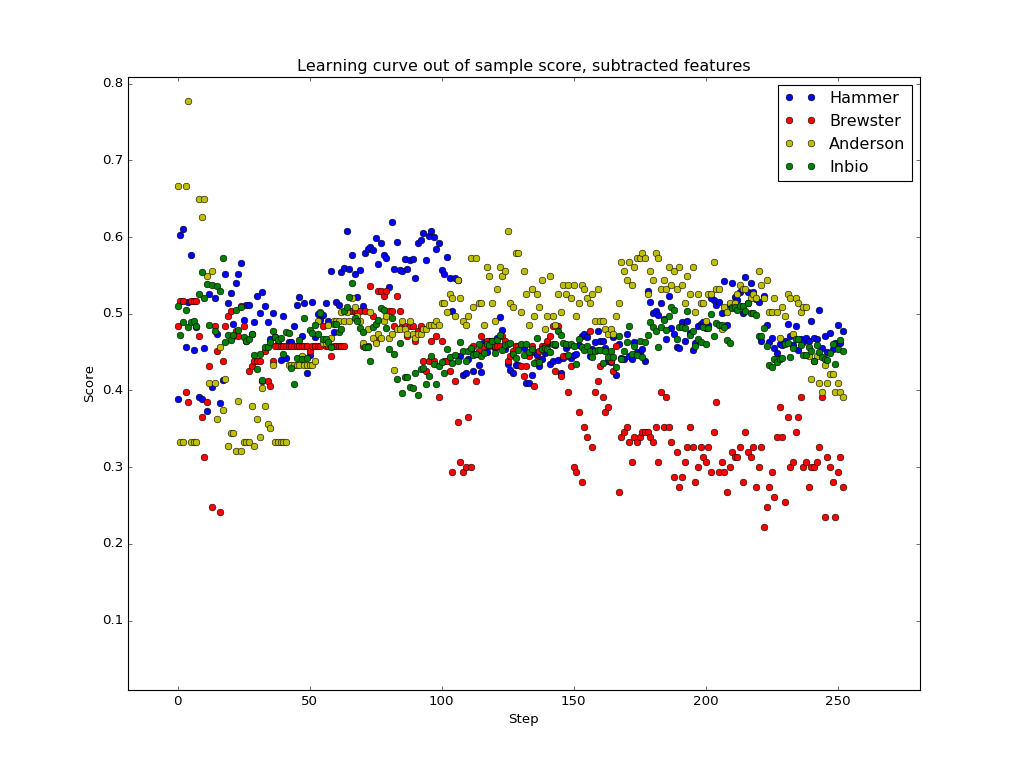

In [46]:
%matplotlib notebook
plt.title("Learning curve out of sample score, subtracted features")
colors = ['bo','ro','yo','go','wo','mo','co','ko','bo','co']
plt.plot(range(len(dfId)),scoresHammer[:len(dfId)], colors[0], label="Hammer")
plt.plot(range(len(dfId)),scoresBrewster[:len(dfId)], colors[1], label="Brewster")
plt.plot(range(len(dfId)),scoresAnderson[:len(dfId)], colors[2], label="Anderson")
plt.plot(range(len(dfId)),scoresInbio[:len(dfId)], colors[3], label="Inbio")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Score")

<IPython.core.display.Javascript object>


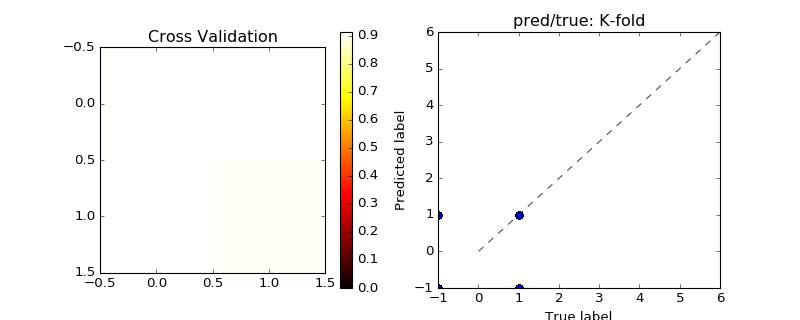

K FOLD CV 
---------- 

 Maximum Score:  0.913248069498 
 Mean optimal score:  0.91092819111 
 sd optimal scores:  0.003280803479099022 
 Optimal parEval:
 [ 0.1  0.1] 
 parEval Scores:
 [[ 0.90860831  0.90728117]
 [ 0.91324807  0.90576737]] 





In [3]:
%timeit

#plt.close('all')

#----parEvalS --------------
Xdf = positionBox
X = positionMatrix
y = yString

regType = 'SVC'
poly= 3

kernel = 'poly'
parLabel = ['C']
parRange = [2]

k = 2
kInner = 5


##OPTIONAL
n_jobs=8
treeCount = 40
gamma = 0.1
alpha = 0.1
coef0 = 1
penalty = 0.1
epsilon = 1
#---------------------------

parModel = {"regType":regType, "poly":poly, "kernel":kernel, "treeCount":treeCount, "coef0":coef0, 'gamma':gamma}


#

if len(parLabel) is 1: 
    scoresParCV, optimalParCV = KfoldCV(X,y,k,parModel,parLabel[0],parRange[0]) 
    #scoresParNCV, optimalParNCV, scoresNCV = nestedKfoldCV(X,y,k,kInner,parModel,parLabel[0],parRange[0])    
    meanScores = np.mean(np.ndarray.max(scoresParCV,axis=1))
    print("K FOLD CV \n---------- \n\n Maximum Score: ",np.max(scoresParCV), "\n Mean optimal score: ", meanScores ,"\n sd optimal scores: ", math.sqrt(np.sum(np.power((np.ndarray.max(scoresParCV,axis=1)-meanScores),2)))   , "\n Optimal parEval:\n", optimalParCV, "\n parEval Scores:\n", scoresParCV,"\n\n\n")
    #print("NESTED K FOLD CV \n----------------- \n\n Maximum Score: ",np.max(scoresParNCV), "\n Mean optimal score: ", np.mean(scoresParNCV) ,"\n sd optimal scores: ", math.sqrt(np.sum(np.power((np.ndarray.max(scoresParCV,axis=1)-np.mean(scoresParNCV)),2))) , "\n Optimal parEval:\n", optimalParNCV, "\n parEval Scores:\n", scoresParNCV,"\n\n\n")

if len(parLabel) is 2:
    evaluateMultiPar(X, y, parModel, parLabel, parRange)

    

In [8]:
X = positionMatrix
y = yString

regType = 'SVC'
poly= 3

kernel = 'poly'
C= 0.1
gamma = 0.1
parModel = {"regType":regType, "poly":poly, "kernel":kernel, "treeCount":treeCount, "coef0":coef0, 'gamma':gamma, 'C':C}

clf = selectRegression(**parModel)
clf.fit(X,y)
hammerScore = clf.score(hammerBox,yHammer)
inbioScore = clf.score(inbioBox,yInbio)
brewsterScore = clf.score(brewsterBox,yBrewster)
andersonScore = clf.score(andersonBox,yAnderson)


0.526984126984127

In [9]:
inbioScore = clf.score(inbioBox,yInbio)
brewsterScore = clf.score(brewsterBox,yBrewster)
andersonScore = clf.score(andersonBox,yAnderson)


In [10]:
inbioScore

0.48642533936651583

In [11]:
brewsterScore

0.26797385620915032

In [12]:
andersonScore

0.50877192982456143